<a href="https://colab.research.google.com/github/JCaballerot/Consultoria_ASEI/blob/main/Model_development/JesusMaria/modelDevelopment_zona1_JM_rev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1 align=center><font size = 5>Forecasting Jesus Maria Zona 1
</font></h1>

---

## Introducción



El presente documento tiene como objetivo exponer el desarrollo metodológico del modelo de predicción de venta de inmuebles elaborados para el distrito de <b>Jesús María - Zona 1</b>.



## Desarrollo general



El desarrollo metodológico utilizado consta de 4 etapas las cuales se dividen en:

>**1. Feature Engineering:** \
>
>Consiste en generar nuevas variables derivadas de las extraidas de las fuentes macro y ASEI. Ejemplo: Promedios de la variable y ratios de la variable en distintas ventanas. Este es un paso muy importante en el desarrollo de ML porque permitirá generar data estable y que pueda caracterizar la data de forma más completa.\
\
**2. Modelo ARIMA:** \
Generaremos un modelo ARIMA basado en el aprendizaje de la misma serie temporal tomando como input la misma serie y su comportamiento histórico. El objetivo principal acá será aprender de la tendencia y estacionariedad que presenta la serie temporal.\
\
**3. Modelo de regresión:**\
En esta etapa utilizaremos todas las variables macro y variables ASEI generadas previamente así como su feature engineering. El objetivo de este punto será generar un modelo que aprenda de la sensibilidad de las variables macro y ASEI respecto a nuestra variable objetivo (El precio del inmueble). La primera opción metodológica es un modelo VAR (de vectores autoregresivos), sin embargo si no se obtuvieran los resultados deseados se optó por un modelo de regresión lineal.\
\
**4. Ensamble de modelos:** \
Finalmente el último pasoconsiste en ensamblar los modelos desarrollados en la etapa 2 y 3, esto con el objetivo que ambos tengan un peso en la estimación final del número de ventas de inmuebles. En los modelos de Miraflores se usó la metodología de ensamble por medias y en Jesús María se utilizaron modelos var (Vectores autorregresivos) para ensamblar los modelos.

---

Resumen:

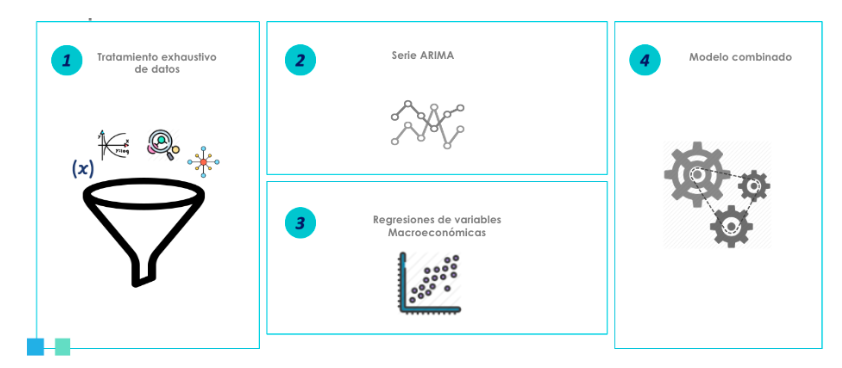

---

## Tabla de Contenidos

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
    
1. <a href="#item1">Importación de librerías y dependencias</a>  
2. <a href="#item2">Carga y preparación del Dataset</a>  
3. <a href="#item3">Modelo de forecasting</a>  
4. <a href="#item4">Pre-selección para regresión</a>  
5. <a href="#item5">Modelo de regresión</a>  
6. <a href="#item6">Implementación</a>  

</font>
</div>

# 1. Importación de librerías y dependencias



Cargamos las librerías y principales dependencias que utilizaremos en el notebook.

---

In [ ]:
# Cargando pandas
import pandas as pd

# Cargando numpy
import numpy as np
from numpy import log

# Cargando librerías gráficas
import matplotlib.pyplot as plt                  
import seaborn as sns                            

# Cargando sklearn para las métricas de evaluación
from sklearn.metrics import *

# Cargando limpieza de warnings durante las ejecuciones
import warnings                                  
warnings.filterwarnings('ignore')

# Librería para guardar objetos
import pickle

# Librerías necesarias para el entrenamiento de modelos
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


In [ ]:
# Cargando funciones user defined

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend",  color='red')

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xticks(rotation=90)

# 2. Carga y preparación del Dataset

Importamos la información desde un archivo csv cargado en el file temporal y nos quedamos con los datos que utilizaremos para el modelo.

---

In [ ]:
# Configuración inicial

# Target a modelar
target = 'Venta_zona_1'

# datos de la zona a modelar
pddf = pd.read_csv('datos_jesusmaria.csv', delimiter=';', index_col=['codmes'], parse_dates=['codmes']).fillna(0)

# variables macro
macro = pd.read_csv('macros_corregido.csv', index_col=['codmes'], parse_dates=['codmes']).drop(columns=['imp_mater_const'])

# variables complementarias ASEI
asei = pd.read_csv('variables_asei_new.csv', delimiter = ';', index_col=['codmes'], parse_dates=['codmes'])


#### Tratamiento de la variable target



Generamos dataset con la variable objetivo y la rezagamos 2 y 3 meses (esto debido a que para su uso tendremos disponibles las ventas del mes pasado o de hace dos meses).

In [ ]:
pddf = pddf[[target]]
pddf[target+'_lag2'] = pddf[target].shift(2)
pddf[target+'_lag3'] = pddf[target].shift(3)

#### Rezago de las variables ASEI


Generamos un rezago de 2 meses de las variables ASEI, esto debido a que la información estará disponible respecto al mes anterior de la estimación.


In [ ]:
variables_asei = asei.columns.tolist()
asei[variables_asei] = asei[variables_asei].shift(2)


#### Rezago de las variables macro


Generamos un rezago de 3 meses de las variables macro, esto debido a que la información macro puede tener mayor demora de carga por las páginas que las reportan.


In [ ]:
variables_macro = macro.columns.tolist()
macro[variables_macro] = macro[variables_macro].shift(3)


#### Cruce de información


Generamos la tabla maestra con todas las fuentes tratadas en pasos anteriores.


In [ ]:
pddf2 = pd.merge(pddf,  macro, on = 'codmes', how='left').copy()
pddf2 = pd.merge(pddf2, asei, on = 'codmes', how='left')

variables = variables_macro + variables_asei + [target+'_lag2', target+'_lag3']

Generamos variables promedio de los últimos 3 y 6 meses de cada una de las variables analizadas.

In [ ]:
pddfRes = pddf2.copy()

pddfRes[[x + '_avg3' for x in variables]] = pddfRes[variables].rolling(3, min_periods = 3).mean()
pddfRes[[x + '_avg6' for x in variables]] = pddfRes[variables].rolling(6, min_periods = 6).mean()

pddfRes = pddfRes.iloc[8:]
pddfRes['intercept'] = 1

Generamos variables ratio de evolución dividiendo las variables generadas en el paso anterior (3/6).

In [ ]:
for x in variables:
  pddfRes[x + '_rat3to6'] = pddfRes[x + '_avg3']/pddfRes[x + '_avg6']
  

Guardamos en una lista todas las variables que probaremos.

In [ ]:
variables_f = variables_macro +\
              variables_asei +\
              [target+'_lag2', target+'_lag3'] +\
              [x + '_avg3' for x in variables] +\
              [x + '_avg6' for x in variables] +\
              [x + '_rat3to6' for x in variables]


#### Generamos la base de test para el modelo

Tomamos sólo dos meses debido a que priorizaremos utilizar la información para el entrenamiento debido a que hay muy poco comportamiento en periodo post-covid.

In [ ]:
test_size = 2

data = pddfRes.copy().dropna()
X_train = pddfRes[:-test_size].dropna()
X_test  = pddfRes[-test_size:].dropna()


Estandarizamos la data restándole a cada variable su media y dividiendo entre su respectiva desviación estándar.

In [ ]:
# Estandarización
X_train[[x + '_std' for x in variables_f]] = (X_train[variables_f] - X_train[variables_f].mean())/X_train[variables_f].std()
X_test[[x + '_std'  for x in variables_f]] = (X_test[variables_f]  - X_train[variables_f].mean())/X_train[variables_f].std()
data[[x + '_std'    for x in variables_f]] = (data[variables_f]    - X_train[variables_f].mean())/X_train[variables_f].std()

# 3. Modelo de Forecasting

### Análisis gráfico

In [ ]:
plotMovingAverage(data[target], 6)

In [ ]:
plotMovingAverage(data[target], 6, plot_intervals=True, scale=1.64, plot_anomalies=False)

In [ ]:


result = adfuller(X_train[target].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.887461
p-value: 0.000037


Dado que el valor p es mayor que el nivel de significancia (0,05), diferenciemos las series y veamos cómo se ve el gráfico de autocorrelación.

In [ ]:

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(X_train[target]); axes[0, 0].set_title('Original Series')
plot_acf(X_train[target], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(X_train[target].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(X_train[target].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(X_train[target].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(X_train[target].diff().diff().dropna(), ax=axes[2, 1])

plt.xticks(rotation=90)
plt.show()

Por los datos anteriores, podemos ver que la serie de tiempo alcanza la estacionariedad con dos órdenes de diferenciación.

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(X_train[target].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(X_train[target].diff().dropna(), ax=axes[1])

plt.xticks(rotation=90)
plt.show()

Podemos ver que el retraso 1 de PACF es bastante significativo ya que está muy por encima de la línea de significancia. Entonces, fijaremos el valor de p como 1.

### MA (q) 

In [ ]:

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(X_train[target].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(X_train[target].diff().dropna(), ax=axes[1])
plt.xticks(rotation=90)
plt.show()


Podemos ver que un 1 retraso están muy por encima de la línea de significación. Entonces, fijaremos q como 1. Si hay alguna duda, iremos con el modelo más simple que explica suficientemente la Y

### Arima

Ahora, hemos determinado los valores de p, d y q. Disponemos de todo lo necesario para adaptarse al modelo ARIMA. Usaremos la implementación ARIMA() en el paquete statsmodels.
(p,d,q)

In [ ]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(X_train[target], label='Original Series')
axes[0].plot(X_train[target].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(X_train[target], label='Original Series')
axes[1].plot(X_train[target].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Ventas Zona 3', fontsize=16)
plt.xticks(rotation=90)
plt.show()

In [ ]:


features = [target + '_lag3_avg3']

# 2,1,1 ARIMA Model
model = ARIMA(endog = X_train[target], 
              exog = X_train[features],  
              order=(1,2,1))

model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D2.Venta_zona_1   No. Observations:                   44
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -194.030
Method:                       css-mle   S.D. of innovations             18.885
Date:                Mon, 25 Jul 2022   AIC                            398.060
Time:                        07:08:49   BIC                            406.981
Sample:                             2   HQIC                           401.369
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.8765      2.350      0.373      0.711      -3.730       5.483
Venta_zona_1_lag3_avg3    -0.0158      0.041     -0.383      0.704      -0.097       0.065
ar.L

In [ ]:

pickle.dump(model_fit, open("./arima_jmz1.ml", 'wb'))

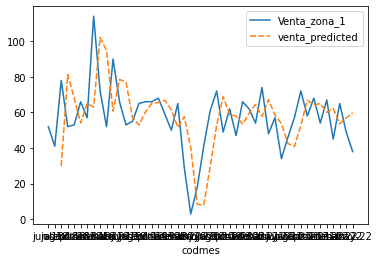

In [ ]:

fc, se, conf  = model_fit.forecast(test_size, exog = X_test[features], alpha=0.05)
model_res = model_fit.predict(start = X_train.index[2], 
                                end = X_train.index[-1], dynamic=False, typ = 'levels')

data_res = data.copy()
data_res['venta_predicted'] = model_res
data_res.iloc[-test_size:]['venta_predicted'] = fc

sns.lineplot(data = data_res[[target, 'venta_predicted']])


In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Los errores residuales parecen correctos con una media cercana a cero y una varianza uniforme. Grafiquemos los valores reales contra los valores ajustados usando plot_predict().

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
data_res[['venta_predicted',target]]

In [ ]:
data_res[['venta_predicted',target]].to_csv('results_JM_zona1.csv', index=0)

In [ ]:

data = data_res.copy().dropna()
X_train = data_res[:-test_size].dropna()
X_test  = data_res[-test_size:].dropna()



In [ ]:
X_test[['venta_predicted', target]]

,venta_predicted,Venta_zona_1
codmes,,
abr-22,56.917399,49
may-22,59.811991,38


In [ ]:
X_test[['venta_predicted', target]].corr()**2

,venta_predicted,Venta_zona_1
venta_predicted,1.0,1.0
Venta_zona_1,1.0,1.0


# Inputs Regresión

In [ ]:
correlations = pd.DataFrame()

for col in variables_f:
  data_temp = X_train[[target, col]]
  correlation = data_temp[col].corr(data_temp[target])
  temp = pd.DataFrame({'target': [target],'variable': [col], 'correlacion' : [correlation]})
  correlations = correlations.append(temp)

correlations['correlacion_abs'] = correlations.correlacion.apply(lambda x: abs(x))
correlations['r2'] = correlations.correlacion.apply(lambda x: x**2)

correlations.sort_values(by = 'correlacion_abs', ascending = False, inplace = True)


In [ ]:
correlations.head(50)

# Regresion

In [ ]:

features = ['intercept', 'ind_prec_inm_rat3to6_std', 'ind_prec_inf_suby_bienes_avg6_std']

# Fit and summarize OLS model
mod = sm.OLS(X_train[target], 
             X_train[features])

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           Venta_zona_1   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     5.614
Date:                Mon, 25 Jul 2022   Prob (F-statistic):            0.00700
Time:                        07:09:16   Log-Likelihood:                -182.87
No. Observations:                  44   AIC:                             371.7
Df Residuals:                      41   BIC:                             377.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
interc

In [ ]:


sn.heatmap(X_train[features].corr(), annot=True)
plt.show()

In [ ]:

data_res['macro_pred'] = 57.6329 + 7.6093*data_res.ind_prec_inm_rat3to6_std + 5.9194*data_res.ind_prec_inf_suby_bienes_avg6_std

data = data_res.copy().dropna()
X_train = data[:-test_size].dropna()
X_test  = data[-test_size:].dropna()


In [ ]:
#target + '_lag3_avg3'
ensemble = ['venta_predicted', 'macro_pred']

# 2,1,1 ARIMA Model
model_ff = ARIMA(endog = X_train[target], 
                 exog = X_train[ensemble],  
                 order=(1,2,1))

model_fit_ff = model_ff.fit()
print(model_fit_ff.summary())

                             ARIMA Model Results                              
Dep. Variable:        D2.Venta_zona_1   No. Observations:                   42
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -183.694
Method:                       css-mle   S.D. of innovations             18.178
Date:                Mon, 25 Jul 2022   AIC                            379.389
Time:                        07:09:30   BIC                            389.815
Sample:                             2   HQIC                           383.210
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.2984      5.381      0.241      0.811      -9.249      11.846
venta_predicted          -0.0777      0.043     -1.789      0.082      -0.163       0.007
macro_pr

In [ ]:

pickle.dump(model_fit_ff, open("./var_jmz1.ml", 'wb'))


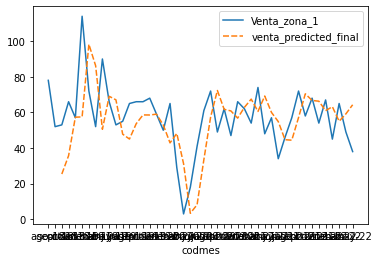

In [ ]:

fc, se, conf  = model_fit_ff.forecast(test_size, 
                                      exog = X_test[['venta_predicted', 'macro_pred']], alpha=0.05)

model_res = model_fit_ff.predict(start = X_train.index[2], 
                                 end = X_train.index[-1], dynamic=False, typ = 'levels')

data_res = data.copy()
data_res['venta_predicted_final'] = model_res
data_res.iloc[-test_size:]['venta_predicted_final'] = fc

sns.lineplot(data = data_res[[target, 'venta_predicted_final']])


In [ ]:
data_res[[target, 'venta_predicted', 'macro_pred', 'venta_predicted_final']]

,Venta_zona_1,venta_predicted,macro_pred,venta_predicted_final
codmes,,,,
ago-18,78,29.854771,46.151464,NaN
sept-18,52,81.344880,51.063465,NaN
oct-18,53,68.027737,62.766374,25.395691
nov-18,66,54.055231,71.138221,35.686034
dic-18,57,65.004536,79.754243,57.319685
ene-19,114,63.069729,73.432620,57.475896
feb-19,72,102.021251,66.271547,98.272622
mar-19,52,94.778900,55.486042,86.208317
abr-19,90,60.682221,54.707229,50.532686


In [ ]:
mod = sm.OLS(X_train[target], X_train[['venta_predicted', 'macro_pred', 'intercept']])
res = mod.fit()
print(res.summary())

In [ ]:

data_res['venta_predicted_final'] = 0.1938*data_res.venta_predicted + 0.9125*data_res.macro_pred - 6.1913

data = data_res.copy().dropna()
X_train = data[:-test_size].dropna()
X_test  = data[-test_size:].dropna()



In [ ]:
X_train[['venta_predicted_final', target]].corr()**2

,venta_predicted_final,Venta_zona_1
venta_predicted_final,1.000000,0.250031
Venta_zona_1,0.250031,1.000000


In [ ]:
data[['venta_predicted',
      'venta_predicted_final', target]].to_csv('results_zona1.csv', index=0)

In [ ]:
data[['venta_predicted',
      'venta_predicted_final', target]]

In [ ]:
X_test[features]

,Venta_zona_1_lag3_avg3
codmes,
abr-22,63.000000
may-22,55.333333


# Implementación

In [ ]:
data[['Venta_zona_1_lag3_avg3', 'ind_prec_inm_rat3to6_std', 'ind_prec_inf_suby_bienes_avg6_std']]

In [ ]:
input = pd.DataFrame({'Venta_zona_1_lag3_avg3' : [57, 60, 58, 59, 58, 58],
                      'ind_prec_inm_rat3to6_std' : [-0.273022]*6,
                      'ind_prec_inf_suby_bienes_avg6_std' : [2.846129]*6
                      },
                     
                      index = ['jun-22', 'jul-22', 'ago-22', 'sept-22', 'oct-22', 'nov-22'])

In [ ]:
fc_pred, se, conf  = model_fit.forecast(6, exog = input['Venta_zona_1_lag3_avg3'], alpha=0.05)
input['venta_predicted'] = fc_pred
fc_pred

array([57.01220105, 59.92785964, 58.49627096, 58.69950096, 58.19935958,
       57.9197205 ])

In [ ]:
input['macro_pred'] = 57.6329 + 7.6093*input.ind_prec_inm_rat3to6_std + 5.9194*input.ind_prec_inf_suby_bienes_avg6_std
#input['venta_predicted_final'] = 0.1938*input.venta_predicted + 0.9125*input.macro_pred - 6.1913


In [ ]:
fc_pred, se, conf  = model_fit_ff.forecast(6, exog = input[['venta_predicted', 'macro_pred']], alpha=0.05)
input['venta_predicted_final'] = fc_pred
input['venta_predicted_final']
fc_pred

array([59.4664363 , 64.85328155, 66.80288093, 71.00679784, 75.25258639,
       80.45001742])